In [9]:
import math
from scipy import signal
from PIL import Image
import numpy
from numpy import *
from matplotlib import pyplot as plt
from pylab import *
import cv2
import random

In [10]:
def gmask (x,y,s): # the function for gaussian filter
    gmask = numpy.exp(-((x**2) + (y**2))//2//s**2)
    return gmask

size  = 2
s = 1.5
G = [] # Gaussian Kernel
for i in range(-size,size+1):
    G.append(gmask(i,0,s)) # equating y to 0 since we need a 1D matrix

In [11]:
def DoLow (I): # the function down samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Apply x mask
           2) Delete Alternate Columns
           3) Apply y mask
           4) delete alternate rows
           The ouput image is of size (r//2)x(c//2)'''
    #========= Applying X mask ====================
    '''
    Ix = []
    for i in range(len(I[:,0])):
	Ix.extend([signal.convolve(I[i,:],G,'same')]) # Ix*Gx = Ix
    Ix = array(matrix(Ix))
    '''
    #========selecting alternate columns===========
    Ix = I
    Ix = Ix[:,::2]
    #========= Applying Y mask ====================
    '''
    Ixy = []
    for i in range(len(Ix[0,:])):
	Ixy.extend([signal.convolve(Ix[:,i],G,'same')]) # Ix * Gy = Ixy
    Ixy = array(matrix(transpose(Ixy)))
    '''
    #========selecting alternate rows===========
    Ixy = Ix
    Ixy = Ixy[::2,:]
    return Ixy # Returning Ixy...

In [12]:
def DoHigh (I,G): # the function up samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Insert zero column on every alternate columns
           2) Apply x mask
           3) Insert zero row on every alternate rows
           4) Apply y mask
           The ouput image is of size (2r)x(2c)'''
    G = numpy.dot(2,G) # Doubing the Guassian kernel since we later use alternate rows and columns
    #=========== Inserting alternate columns of zeros ========
    newI = numpy.zeros(shape=(shape(I)[0],2*shape(I)[1]))
    newI[:, ::2] = I
    #========= Applying X mask ====================
    '''
    Ix = []
    for i in range(len(newI[:,0])):
	Ix.extend([signal.convolve(newI[i,:],G,'same')]) # newI*G ----> x direction
    Ix = array(matrix(Ix))
    '''
    #=========== Inserting alternate rows of zeros ========
    Ix = newI
    newI = numpy.zeros(shape=(2*shape(Ix)[0],shape(Ix)[1]))
    newI[::2] = Ix
    #========= Applying Y mask ====================
    Ixy = newI
    '''
    Ixy = []
    for i in range(len(newI[0,:])):
	Ixy.extend([signal.convolve(newI[:,i],G,'same')]) # Ixy
    Ixy = array(matrix(transpose(Ixy)))
    '''
    return Ixy # Return Ixy...

In [13]:
def lk1(H #Frame 1
        ,I # Frame 2
        ):
    '''
        This function implements the LK optical flow estimation algorithm with two frame data.
        We use this function to return the derivative and vector values for the current section so that it can be used iteratively in lksection function
        '''
    # First Derivative in X direction
    fx = signal.convolve2d(H,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,0.25],[-0.25,0.25]],'same')
    # First Derivative in Y direction
    fy = signal.convolve2d(H,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,-0.25],[0.25,0.25]],'same')
    # First Derivative in XY direction
    ft = signal.convolve2d(H,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,-0.25],[-0.25,-0.25]],'same')
    # Initializing the u and v arrays with non numbers so that we don't have to plot the irrelevant vectors later
    #u = numpy.nan * numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    #v = numpy.nan * numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    u = numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    v = numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    # Determining the good features
    gf = cv2.goodFeaturesToTrack(H # Input image
                                 ,10000 # max corners
                                 ,0.01 # lambda 1 (quality)
                                 ,10 # lambda 2 (quality)
                                 )

    # Calculating the u and v arrays for the good features obtained n the previous step.
    for a in gf:
        j,i = a.ravel()
        # calculating the derivatives for the neighbouring pixels
        # since we are using  a 3*3 window, we have 9 elements for each derivative.
        i = int(i)
        j = int(j)
        FX = ([fx[i-1,j-1],fx[i,j-1],fx[i-1,j-1],fx[i-1,j],fx[i,j],fx[i+1,j],fx[i-1,j+1],fx[i,j+1],fx[i+1,j-1]])
        FY = ([fy[i-1,j-1],fy[i,j-1],fy[i-1,j-1],fy[i-1,j],fy[i,j],fy[i+1,j],fy[i-1,j+1],fy[i,j+1],fy[i+1,j-1]])
        FT = ([ft[i-1,j-1],ft[i,j-1],ft[i-1,j-1],ft[i-1,j],ft[i,j],ft[i+1,j],ft[i-1,j+1],ft[i,j+1],ft[i+1,j-1]])
        # Using the minimum least squares solution approach
        A = (FX,FY)
        A = matrix(A)
        AT = array(matrix(A))
        A = array(numpy.matrix.transpose(A))
        #Psedudo Inverse
        U1 = numpy.dot(AT,A)
        U2 = numpy.linalg.pinv(U1)
        U3 = numpy.dot(U2,AT)
        (u[i,j],v[i,j]) = numpy.dot(U3,FT) # we have the vectors with minimized square error

    u = numpy.flipud(u)
    v = numpy.flipud(v)
    return u,v

In [14]:
def lksection (I1 # frame 1
               ,I2 # frame 2
               ,uin # u from previous level
               ,vin # v from previous level
               ):
    '''This function runs the LK Algorithm for the current section of pyramid iteratively.
    We take a window of 5x5 and move from left top corner to right bottom corner in order to calculate the vectors for that window.
    Once the whole image is done, we sum the vectors of current and previous levels.
    '''

    uin = numpy.round(uin)
    vin = numpy.round(vin)
    u = numpy.zeros(shape(I1));
    v = numpy.zeros(shape(I2));


    for i in range (2,len(I1[:,0])-2):
        for j in range (2,len(I2[0,:])-2):
            i = int(i)
            j = int(j)
            I1current = I1[i-2:i+3,j-2:j+3] # picking 5x5 pixels at a time
            lri = (i-2)+vin[i,j] #Low Row Index of the selected window
            hri = (i+2)+vin[i,j] #High Row Index of the selected window
            lci = (j-2)+uin[i,j] #Low Column Index of the selected window
            hci = (j+2)+uin[i,j] #High Column Index of the selected window

            #============= 5 x 5 Window search ===============
            '''When the 5x5 window goes beyond the resolution of the concerned image
            we choose the ending 5x5 window for that image.
            '''
            if(lri < 0): # if the window goes towards the left of the image
                lri = 0
                hri = 4
            if(lci < 0): # if the window goes above the image
                lci = 0
                hci = 4
            if(hri > (len(I1[:,0]))-1): #if the window goes towards the right of the image
                lri = len(I1[:,0])-5
                hri = len(I1[:,0])-1
            if(hci > (len(I1[0,:]))-1): # if the window goes below the image
                lci = len(I1[0,:])-5
                hci = len(I1[0,:])-1
            if(numpy.isnan(lri)):
                lri = i-2
                hri = i+2
            if(numpy.isnan(lci)):
                lci = j-2
                hci = j+2
            
            hci = int(hci)
            hri = int(hri)
            lci = int(lci)
            lri = int(lri)

            #Selecting the same window for the second frame
            I2current = I2[lri:(hri+1),lci:(hci+1)]
            # Now applying LK for each window of the 2 images
            fx = signal.convolve2d(I1current,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,0.25],[-0.25,0.25]],'same')
            fy = signal.convolve2d(I1current,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,-0.25],[0.25,0.25]],'same')
            ft = signal.convolve2d(I1current,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,-0.25],[-0.25,-0.25]],'same')

            FX =numpy.transpose(fx[1:5,1:5])
            FY = numpy.transpose(fy[1:5,1:5])
            FT = numpy.transpose(ft[1:5,1:5])

            FX = FX.ravel()
            FY = FY.ravel()
            FT = FT.ravel()

            A = (FX,FY)
            A = matrix(A)
            AT = array(matrix(A))
            A = array(numpy.matrix.transpose(A))

            U1 = numpy.dot(AT,A)
            U2 = numpy.linalg.pinv(U1)
            U3 = numpy.dot(U2,AT)
            (u[i,j],v[i,j]) = numpy.dot(U3,FT)

    u = u+uin
    v = v+vin
    # Taking the reciprocal of the condition number for A
    c = numpy.mat(transpose(A))*numpy.mat(A)
    c = 1.0//(linalg.cond(c))
    return u,v,c

In [19]:
def runproglk (I1,
               I2,
               iternum, # Number of iterations per level -- we are using 3
               nlev # Number of levels -- we are using 3
               ):
    I1 = array(Image.open(I1).convert('L')) # read the second input frame
    I2 = array(Image.open(I2).convert('L')) # read the second input frame
    ''' The function uses all the above defined function to implement LK algorithm in a multi-resolution Gaussian pyramid
    framework. We use the following :
    window size of 3x3
    Pyramid size = 3 levels
    Starting from the lower most level, at each level we use the iterative LK algorithm and then warp and upsample it so that it can be used for the next level.
    '''
    p1=numpy.empty((len(I1[:,0]),len(I1[0,:]),nlev)) # creating 3d array with different levels for frame 1
    p2=numpy.empty((len(I2[:,0]),len(I2[0,:]),nlev)) # creating 3d array with different levels for frame 2
    p1[:,:,0] = I1 # assign values for Highest level
    p2[:,:,0] = I2 # assign values for Highest level
    '''
    p[:,:,0] ---> Level 2 ---> Highest resolution
    p[:,:,2] ---> Level 0 ---> Least resolution
    '''
    # Defining the lower levels
    for i in range(1,nlev):
        I1 = DoLow(I1)
        I2 = DoLow(I2)
        p1[0:int((len(I1[:,0]))),0:int((len(I1[0,:]))),i] = I1
        p2[0:int((len(I2[:,0]))),0:int((len(I2[0,:]))),i] = I2

    #===================== level 0 - Base====================
    l0I1 = p1[0:int((len(p1[:,0])//4)),0:int((len(p1[0,:])//4)),2]
    l0I2 = p2[0:int((len(p2[:,0])//4)),0:int((len(p2[0,:])//4)),2]
    (u,v)= lk1(I1,I2)
    #============= Iterative LK for that section============
    for j in range(1,iternum+1):
        (u,v,c) = lksection (l0I1,l0I2,u,v)
    #============= Store U and V values ===================
    ul0 = u
    vl0 = v
    Il0 = l0I1
    ul0[numpy.where(ul0 == 0)] = nan
    vl0[numpy.where(vl0 == 0)] = nan
    #====================Level 1===================
    k = 1
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),nlev-k-1]
    (u,v,c) = lksection (I1current,I2current,ue,ve)
    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v,c) = lksection (I1current,I2current,ue,ve)
    #============= Store U and V values ===================
    ul1 = u
    vl1 = v
    Il1 = I1current
    ul1[numpy.where(ul1 == 0)] = nan
    vl1[numpy.where(vl1 == 0)] = nan
    #====================Level 2=========================
    k = 2
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),nlev-k-1]
    (u,v,c) = lksection (I1current,I2current,ue,ve)
    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v,c) = lksection (I1current,I2current,ue,ve)
    #============= Store U and V values ===================
    ul2 = u
    vl2 = v
    Il2 = I1current
    #ul2[numpy.where(ul2 == 0)] = nan
    #vl2[numpy.where(vl2 == 0)] = nan
    #======= Pick Random color for vector plot========
    colors = "bgrcmykw"
    color_index = random.randrange(0,8)
    c=colors[color_index]
    #======= Plotting Level 0========
    plt.figure()
    plt.imshow(Il0,cmap = cm.gray)
    plt.title('Level 0 - Base level')
    quiver(ul0,vl0,color = c)
    #======= Plotting Level 1========
    c=colors[color_index]
    plt.figure()
    plt.imshow(Il1,cmap = cm.gray)
    plt.title('Level 1')
    quiver(ul1,vl1,color = c)
    #======= Plotting Level 2========
    c=colors[color_index]
    plt.figure()
    plt.imshow(Il2,cmap = cm.gray)
    plt.title('Level 2')
    quiver(ul2,vl2,color = c)
    show()
    
    #======= Plotting Final ========
    u_fin = DoHigh(DoHigh (ul0,G),G) +DoHigh (ul1,G) + ul2 
    v_fin = DoHigh(DoHigh (vl0,G),G) +DoHigh (vl1,G) + vl2 
    
    c=colors[color_index]
    plt.figure()
    plt.imshow(Il2,cmap = cm.gray)
    plt.title('Final')
    quiver(u_fin,v_fin,color = c)
    show()

    return(ul0,vl0,Il0,ul1,vl1,Il1,ul2,vl2,Il2)
'''
Since this program takes a lot of time to run.
Uncomment one of the three lines below to implement Lucas-Kanade optical flow estimation algorithm in a multi-resolution Gaussian pyramid
framework for the required pair of images
########################################## Run the Program for one pair of images at a time ######################################################
'''

'\nSince this program takes a lot of time to run.\nUncomment one of the three lines below to implement Lucas-Kanade optical flow estimation algorithm in a multi-resolution Gaussian pyramid\nframework for the required pair of images\n########################################## Run the Program for one pair of images at a time ######################################################\n'

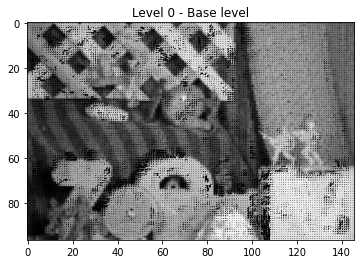

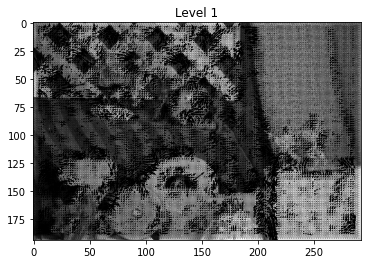

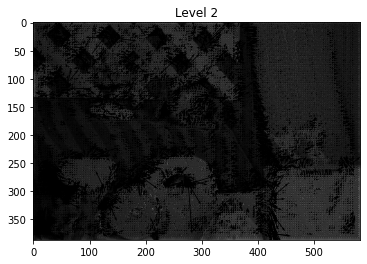

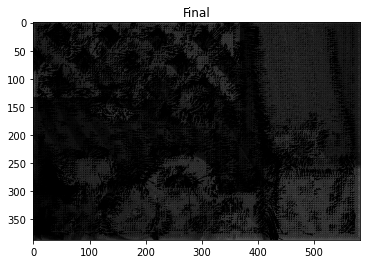

In [20]:
(ul01,vl01,Il01,ul11,vl11,Il11,ul21,vl21,Il21) = runproglk('dataset/eval-data-gray/Army/frame07.png','dataset/eval-data-gray/Army/frame08.png',3,3)
